In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#import sys 
#sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##3D MRI BRAIN imgae Super Resolution 




Beomjin Seo,

Biomedical Engineering & SoftwareConvergence

#Overview 
HR MRI는 성능은 좋은 특성이 있지만 상대적으로 긴 스캔 시간, 더 작은 spatial coverage, lower signal-to-noise ratio(SNR)를 가지는 단점이 있다. 또한 종종 artifact가 섞이는 결과가 나오고는 한다. 한편, 최근 연구는 저화지의 이미지를 고화질로 바꾸는 super resolution을 MRI image에 적용해, HR MRI 이미지의 단점의 대안책이 되게 하고 있다. 모델의 성능과 비용 또한 중요한 관건이 되겠될 수 있는데, 오늘의 모델들은 시간이 갈수록 가벼워지면서 좋은 성능을 내고 있다. 이번 프로젝트에서 제시할 모델은 mDCSRN-GAN으로, LR 이미지를 입력으로 주면, 모델 내에서 생성기와 분별기가 학습을 반복하며 super resolution image(SR image)를 출력해 낸다. 

In [3]:
from __future__ import print_function
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

import os
import random
import time
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from scipy import ndimage
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
# from torch.optim import lr_scheduler


# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


#Input
Parameter setting

Here we define some inputs for the run:

vm_PATH - the path of folder in your local machine that mounts google storage

id_csv - the path to the .csv file that has id of subjects

workers - the number of worker threads for loading the data with the DataLoader

batch_size - the batch size here in fact determine the number of samples once 
download. We uses a batch size of 2

patch_size - the patch size here in fact determine the number of images (cubes) as the input in one training. We uses a patch size of 2 as is recommended in the paper

cube_size - the spatial size of the images used for training. This implementation defaults to 64x64x64. If another size is desired, the structures of D and G must be changed. See here <https://github.com/pytorch/examples/issues/70>__ for more details

usage - the usage of a patch cluster. usage < 1.0 would mean we choose to randomly give up some patches by this probability

num_steps_pre - the pretraining steps of Generator. By default in paper, this should be 500000. Here we use 250000.

num_steps - the total steps of training. By default in paper, this should be $500000+550000=1050000$. Here we use 550000.

first_steps - the total number of WGAN Discriminator pre-training steps. By default in paper, this should be 10000. 
Here we use 10000.

lr_pre - learning rate for pretraining. As described in the paper, this number should be 1e-4.

lr - learning rate for WGAN training. As described in the paper, this number should be 5e-6.

ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

device - CUDA setting.

In [0]:
# Set pathes

data_path = "/content/gdrive/My Drive/Colab Notebooks/MRI BRAIN image SR/mDCSRN_WGANGP_v2/"
hcp_id_subset_csv = "/content/gdrive/My Drive/Colab Notebooks/MRI BRAIN image SR/mDCSRN_WGANGP_v2/data_prep/HCP_1200_sub.csv"



# Number of workers for dataloader
workers = 1

# Batch size. It controls the number of samples once download
batch_size = 16

# Patch size, it controls the number of patches once send into the model
patch_size = 2

# The size of one image patch (eg. 64 means a cubic patch with size: 64x64x64)
cube_size = 64

# Set the usage of a patch cluster.
usage = 1.0

# Number of mDCSRN (G) pre-training steps (5e6)
num_steps_pre = 250000

# Number of WGAN training steps (1.5e7)
num_steps = 300000        #######수정 450000
 
# Number of WGAN D pre-training steps (1e4)
first_steps = 5000         ##########수정 10000

# Learning rate for mDCSRN (G) pre-training optimizers (in paper: 1e-4)
lr_pre = 1e-4

# Learning rate for optimizers (in paper: 5e-6)
lr = 5e-6

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1   ######수정 gpu1개 이므로. 

# set GPU device
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [5]:
torch.cuda.device_count()

1

#Data loading with online fetching, and patching

In [6]:
#!ls
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/MRI\ BRAIN\ image\ SR/mDCSRN_WGANGP_v2
!ls

/content/gdrive/My Drive/Colab Notebooks/MRI BRAIN image SR/mDCSRN_WGANGP_v2
check_result_test.ipynb  HCP_1200_NPY_LR   models	training_pre_.py
data_prep		 HCP_1200_NPY_LR_  my_models	wgan_gp_v3.py
example_images		 image_test.ipynb  __pycache__	wgan_gp_v3.py.gdoc
HCP_1200		 loss_history	   result
HCP_1200_NPY		 main.ipynb	   test.py


In [0]:
from data_prep.DataProvider import DataProvider
from data_prep.patchloader import patching

Split data

In [8]:
# Set percentage of data spliting
train_split= 0.7
validate_split = 0.1
evaluate_split = 0.1
test_split = 0.1

# Set shuffle and stablize random_seed
shuffle_dataset = True
random_seed= 999

# load data from csv
dataset = DataProvider(hcp_id_subset_csv,data_path)
dataset_size = len(dataset)

# get indices for spliting train, valiadate, evaluate, test sets
train_size = math.ceil(train_split * dataset_size)
validate_size = int(validate_split * dataset_size)
evaluate_size = int(evaluate_split * dataset_size)
test_size = int(dataset_size - train_size - validate_size - evaluate_size)

indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices = indices[:train_size]
# To reduce computational cost in validation period, you can intentionally decrease the validation size. 
loc_val = train_size + validate_size
# loc_val_reduced = train_size + math.ceil(validate_size/3)
# val_indices = indices[train_size:loc_val_reduced]
val_indices = indices[train_size:loc_val]
loc_eval = loc_val + evaluate_size
eval_indices = indices[loc_val:loc_eval]
test_indices = indices[loc_eval:loc_eval+10]
num_train = len(train_indices)
num_val = len(val_indices)
num_eval = len(eval_indices)
num_test = len(test_indices)
print('training set number:{}'.format(len(train_indices)))
print('validation set number:{}'.format(len(val_indices)))
print('evaluation set number:{}'.format(len(eval_indices)))
print('test set number:{}'.format(len(test_indices)))

training set number:572
validation set number:81
evaluation set number:81
test set number:10


The following cell create dataloaders used for pretraining.



In [0]:
# Use for pre-training (we don't want too much validation)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
eval_sampler = SubsetRandomSampler(eval_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=train_sampler,
                                        shuffle=False,
                                        num_workers=workers)
validation_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=valid_sampler,
                                        shuffle=False,
                                        num_workers=workers)
eval_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=eval_sampler,
                                        shuffle=False,
                                        num_workers=workers)
test_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=test_sampler,
                                        shuffle=False,
                                        num_workers=workers)


dataloaders={'train':train_loader, 'val':validation_loader}
dataset_sizes={'train':len(train_sampler), 'val':len(valid_sampler)}


The following cell create dataloaders used for WGAN training.

Since we want more frequent validation to track the performance, we make training dataloaders and validation dataloaders to be interleaved.

In [0]:
# Use for WGAN-training (we want to have more frequent validation)
def chunks(arr, m):
    '''
    This function split the list into m fold.
    '''
    n = int(np.floor(len(arr) / float(m)))
    arr_split = [arr[i:i + n] for i in range(0, len(arr), n)]
    return arr_split

# Split indices
train_indices_split = chunks(train_indices, 10)  ########수정 원래 10 
val_indices_split = chunks(val_indices, 10)      ########수정 원래 10 

dataloaders={'train':[], 'val':[]}
dataset_sizes={'train':[], 'val':[]}
for i in range(10):  ########## 수정 원래 10 
    train_sampler = SubsetRandomSampler(train_indices_split[i])
    valid_sampler = SubsetRandomSampler(val_indices_split[i])
    train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=train_sampler,
                                        shuffle=False,
                                        num_workers=workers)
    validation_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=valid_sampler,
                                        shuffle=False,
                                        num_workers=workers)
    dataloaders['train'].append(train_loader)
    dataloaders['val'].append(validation_loader)
#     dataset_sizes['train'].append(len(train_indices_split[i]))
#     dataset_sizes['val'].append(len(val_indices_split[i]))


#Implementation: Modeling

Weight Initialization



In [0]:
# custom weights initialization called on netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('LayerNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator

In [12]:
ls

check_result_test.ipynb  HCP_1200_NPY_LR/   models/       training_pre_.py
data_prep/               HCP_1200_NPY_LR_/  my_models/    wgan_gp_v3.py
example_images/          image_test.ipynb   __pycache__/  wgan_gp_v3.py.gdoc
HCP_1200/                loss_history/      result/
HCP_1200_NPY/            main.ipynb         test.py


In [13]:

from my_models.mdcsrn_fragment import Generator

# Create the generator
netG = Generator(ngpu).cuda(device)
# Print the model
print(netG)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))

Generator(
  (conv0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (block0): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0, inplace=True)
      (conv): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0, inplace=True)
      (conv): Conv3d(48, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (denselayer3): _DenseLayer(
      (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (elu): ELU(alpha=1.0, inplace=True)
      (conv): Conv3d(64, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (denselayer4): _DenseLayer(
      (nor


Discriminator

In [14]:
from my_models.mdcsrn_fragment import Discriminator

# Create the Discriminator
netD = Discriminator(ngpu).cuda(device)
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

Discriminator(
  (main): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=1)
    (2): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
    (3): LayerNorm((64, 32, 32, 32), eps=1e-05, elementwise_affine=True)
    (4): LeakyReLU(negative_slope=1)
    (5): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (6): LayerNorm((128, 32, 32, 32), eps=1e-05, elementwise_affine=True)
    (7): LeakyReLU(negative_slope=1)
    (8): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
    (9): LayerNorm((128, 16, 16, 16), eps=1e-05, elementwise_affine=True)
    (10): LeakyReLU(negative_slope=1)
    (11): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (12): LayerNorm((256, 16, 16, 16), eps=1e-05, elementwise_affine=True)
    (13): LeakyReLU(negative_slope=1)
    (14): Conv3d(256, 256, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
   

In [0]:
# Initialize Loss functions
# Supervised criterion
supervised_criterion = nn.L1Loss()
# cross-entropy loss for Discriminator alone. 
D_criterion = nn.BCELoss()
# We move wasserstein Loss into the training function.


#Training
Training scheme:

1) non-GAN training: pretrain the generator for 250k steps, use learning rate 1e-4, L1-loss;

2) With GAN training: 550k steps together with the pretraining steps, use learning rate 5e-6, $$ \operatorname{loss}=\operatorname{loss}_{\text { int }}+\lambda \operatorname{loss}_{\text { GAN }} $$

where $\operatorname{loss}_{\mathrm{GAN}}=\operatorname{loss}_{\mathrm{WGAN}, D}=-D_{\mathrm{WGAN}, \theta}\left(I^{\mathrm{SR}}\right).$

3) Train discriminator alone for 10k steps;

4) Imbalanced training: train D 7 steps, train G 1 step;

5) Every 500 steps train D alone for an extra 200 steps.

Pretraining Generator (mDCSRN)



In [16]:
!ls

check_result_test.ipynb  HCP_1200_NPY_LR   models	training_pre_.py
data_prep		 HCP_1200_NPY_LR_  my_models	wgan_gp_v3.py
example_images		 image_test.ipynb  __pycache__	wgan_gp_v3.py.gdoc
HCP_1200		 loss_history	   result
HCP_1200_NPY		 main.ipynb	   test.py


In [0]:
#import os 
#os.getcwd()

In [18]:
from training_pre_ import training_pre

model=training_pre(netG, dataloaders, 
                   dataset_sizes, supervised_criterion, 
                   device, ngpu, max_step=num_steps_pre, 
                   lr=lr_pre, patch_size=patch_size, pretrained='my_models/pretrained_G_step250000')

Generator pre-training...
step :  250000


In [19]:
!ls

check_result_test.ipynb  HCP_1200_NPY_LR   models	training_pre_.py
data_prep		 HCP_1200_NPY_LR_  my_models	wgan_gp_v3.py
example_images		 image_test.ipynb  __pycache__	wgan_gp_v3.py.gdoc
HCP_1200		 loss_history	   result
HCP_1200_NPY		 main.ipynb	   test.py


Training mDCSRN+WGAN-GP



In [20]:
from wgan_gp_v3 import WGAN_GP

wgan_gp = WGAN_GP(netG, netD, supervised_criterion, D_criterion, device, ngpu, lr = lr)
model_G, model_D = wgan_gp.training(dataloaders, max_step=num_steps, first_steps=first_steps, patch_size=patch_size, pretrainedG='my_models/WGAN_G_step255000', pretrainedD='my_models/WGAN_D_step255000')

WGAN training...
Step 255000/300000
----------


RuntimeError: ignored

#Check results

Loss

In [21]:
f=open('loss_history/train_loss_history.txt','rb')
train_loss = pickle.load(f)
f.close()
f=open('loss_history/train_loss_D_history.txt','rb')
train_D_loss = pickle.load(f)
f.close()
f=open('loss_history/val_loss_history.txt','rb')
val_loss = pickle.load(f)
f.close()
f=open('loss_history/val_loss_D_history.txt','rb')
val_D_loss = pickle.load(f)
f.close()
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(train_loss[20000:],label="G")
plt.plot(train_D_loss[20000:],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Validation")
plt.plot(val_loss[1000:],label="G")
plt.plot(val_D_loss[1000:],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

FileNotFoundError: ignored

In [0]:
def check_result_images(step,slice=50):
    f=open('example_images/image_lr_step{}.txt'.format(step),'rb')
    lr_patches = pickle.load(f)
    f.close()
    f=open('example_images/image_sr_step{}.txt'.format(step),'rb')
    sr_patches = pickle.load(f)
    f.close()
    f=open('example_images/image_hr_step{}.txt'.format(step),'rb')
    hr_patches = pickle.load(f)
    f.close()
    f = plt.figure(figsize=(16,16))
    patch_size = lr_patches.shape[0]
    for patch in range(patch_size):
        sp = f.add_subplot(patch_size,3,patch*3+1)
        sp.axis('Off')
        sp.set_title('Low resolution patch', fontsize=16)
        plt.imshow(lr_patches[patch,slice,:,:],cmap='gray')
        
        sp = f.add_subplot(patch_size,3,patch*3+2)
        sp.axis('Off')
        sp.set_title('Super resolution patch', fontsize=16)
        plt.imshow(sr_patches[patch,slice,:,:],cmap='gray')
        
        sp = f.add_subplot(patch_size,3,patch*3+3)
        sp.axis('Off')
        sp.set_title('High resolution patch', fontsize=16)
        plt.imshow(hr_patches[patch,slice,:,:],cmap='gray')


Results of patches

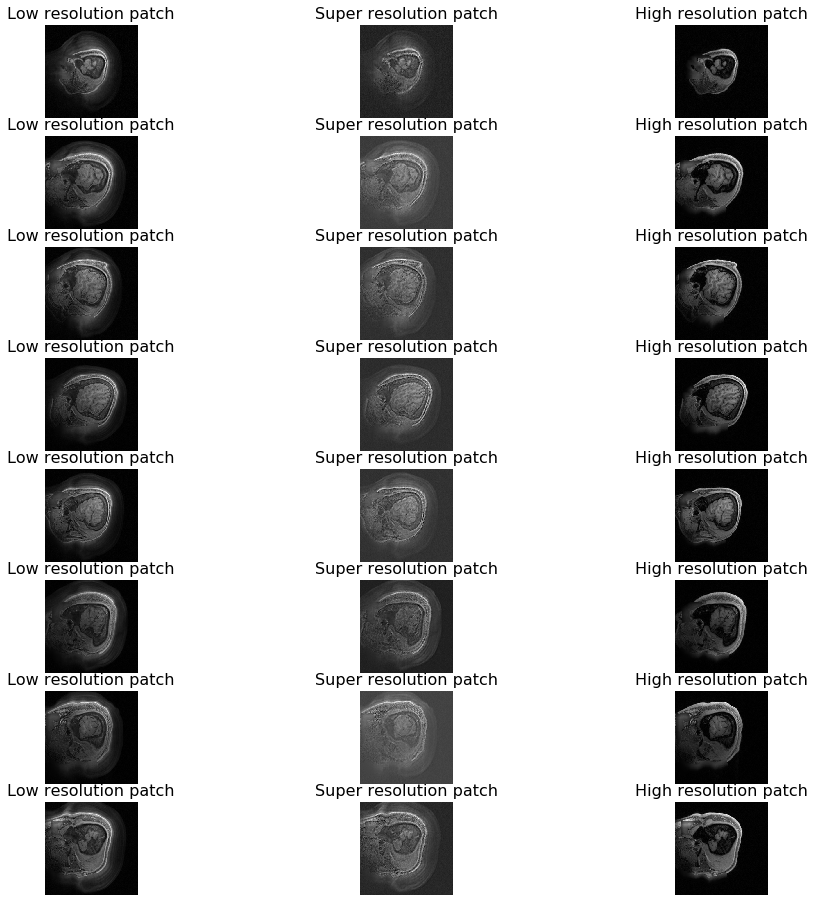

In [26]:
check_result_images(step=254850,slice=40)

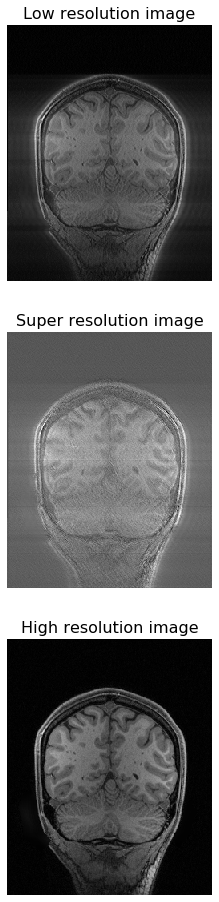

In [27]:
f=open('example_images/image_lr_step254850.txt','rb')
lr_image = pickle.load(f)
f.close()
fig = plt.figure(figsize=(16,16))
sp = fig.add_subplot(3,1,1)
sp.axis('Off')
sp.set_title('Low resolution image', fontsize=16)
lr_show=ndimage.rotate(lr_image[0,:,100,:], 90)
plt.imshow(lr_show,cmap='gray')
f=open('example_images/image_sr_step254850.txt','rb')
sr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,2)
sp.axis('Off')
sp.set_title('Super resolution image', fontsize=16)
sr_show=ndimage.rotate(sr_image[0,:,100,:], 90)
plt.imshow(sr_show,cmap='gray')
f=open('example_images/image_hr_step254850.txt','rb')
hr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,3)
sp.axis('Off')
sp.set_title('High resolution image', fontsize=16)
hr_show=ndimage.rotate(hr_image[0,:,100,:], 90)
plt.imshow(hr_show,cmap='gray')

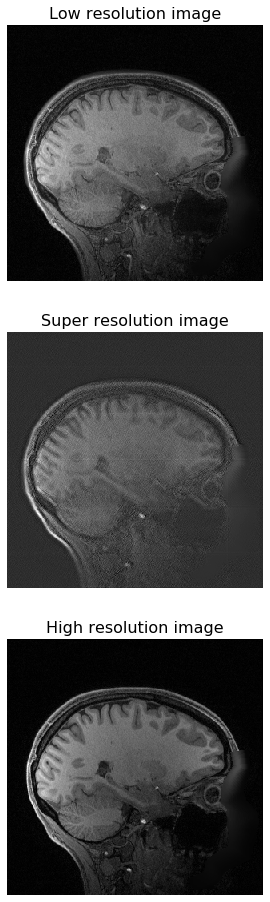

In [28]:
f=open('example_images/image_lr_step254850.txt','rb')
lr_image = pickle.load(f)
f.close()
fig = plt.figure(figsize=(16,16))
sp = fig.add_subplot(3,1,1)
sp.axis('Off')
sp.set_title('Low resolution image', fontsize=16)
lr_show=ndimage.rotate(lr_image[0,100,:,:], 90)
plt.imshow(lr_show,cmap='gray')
f=open('example_images/image_sr_step254850.txt','rb')
sr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,2)
sp.axis('Off')
sp.set_title('Super resolution image', fontsize=16)
sr_show=ndimage.rotate(sr_image[0,100,:,:], 90)
plt.imshow(sr_show,cmap='gray')
f=open('example_images/image_hr_step254850.txt','rb')
hr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,3)
sp.axis('Off')
sp.set_title('High resolution image', fontsize=16)
hr_show=ndimage.rotate(hr_image[0,100,:,:], 90)
plt.imshow(hr_show,cmap='gray')

#Test of depatching, and evaluation metrics



In [0]:
from data_prep.patchloader import depatching
from result.eval_metrics import ssim, psnr, nrmse

#demo of test
We input 10 subjects from test set to see the results.

In [33]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, D_criterion, device, ngpu)
wgan_gp.test(test_loader, patch_size=patch_size, pretrainedG='my_models/pretrained_G_step250000', pretrainedD=' ')

WGAN testing...
Metrics: subject-wise mean SSIM = 0.5810, std = 0.1330; mean PSNR = 20.2104, std = 2.4960; mean NRMSE = 0.8283, std = 0.1550.


In [32]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, D_criterion, device, ngpu)
wgan_gp.test(test_loader, patch_size=patch_size, pretrainedG='my_models/WGAN_G_step255000', pretrainedD='my_models/WGAN_D_step255000')

WGAN testing...
Metrics: subject-wise mean SSIM = 0.6202, std = 0.1230; mean PSNR = 20.7296, std = 2.8384; mean NRMSE = 0.7876, std = 0.1808.


In [0]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, D_criterion, device, ngpu)
wgan_gp.test(test_loader, patch_size=patch_size, pretrainedG=' ', pretrainedD=' ')